In [1]:
# Install gdown to handle Google Drive file download
!pip install -q gdown

import gdown
import zipfile

download_url = f"https://drive.google.com/uc?id=1YkGwaxBKNiYL2nq--cB6WMmYGzRmRKVr"
output_zip = "dlav_train.zip"
gdown.download(download_url, output_zip, quiet=False)  # Downloads the file to your drive
with zipfile.ZipFile(output_zip, 'r') as zip_ref:  # Extracts the downloaded zip file
    zip_ref.extractall(".")

download_url = "https://drive.google.com/uc?id=1wtmT_vH9mMUNOwrNOMFP6WFw6e8rbOdu"
output_zip = "dlav_val.zip"
gdown.download(download_url, output_zip, quiet=False)
with zipfile.ZipFile(output_zip, 'r') as zip_ref:
    zip_ref.extractall(".")

download_url = "https://drive.google.com/uc?id=1G9xGE7s-Ikvvc2-LZTUyuzhWAlNdLTLV"
output_zip = "dlav_test_public.zip"
gdown.download(download_url, output_zip, quiet=False)
with zipfile.ZipFile(output_zip, 'r') as zip_ref:
    zip_ref.extractall(".")

Downloading...
From (original): https://drive.google.com/uc?id=1YkGwaxBKNiYL2nq--cB6WMmYGzRmRKVr
From (redirected): https://drive.google.com/uc?id=1YkGwaxBKNiYL2nq--cB6WMmYGzRmRKVr&confirm=t&uuid=d1cfb202-f73d-40bc-b4f2-129159dcd2b2
To: /content/dlav_train.zip
100%|██████████| 439M/439M [00:04<00:00, 106MB/s]
Downloading...
From (original): https://drive.google.com/uc?id=1wtmT_vH9mMUNOwrNOMFP6WFw6e8rbOdu
From (redirected): https://drive.google.com/uc?id=1wtmT_vH9mMUNOwrNOMFP6WFw6e8rbOdu&confirm=t&uuid=fe242681-97b0-415a-8872-5f8f62d0307c
To: /content/dlav_val.zip
100%|██████████| 87.8M/87.8M [00:00<00:00, 93.7MB/s]
Downloading...
From (original): https://drive.google.com/uc?id=1G9xGE7s-Ikvvc2-LZTUyuzhWAlNdLTLV
From (redirected): https://drive.google.com/uc?id=1G9xGE7s-Ikvvc2-LZTUyuzhWAlNdLTLV&confirm=t&uuid=43433107-1e76-4ba9-a8bf-e2b49b39b2ca
To: /content/dlav_test_public.zip
100%|██████████| 86.6M/86.6M [00:00<00:00, 107MB/s]


Now lets load the data and visualize the first few examples to see what we are dealing with!

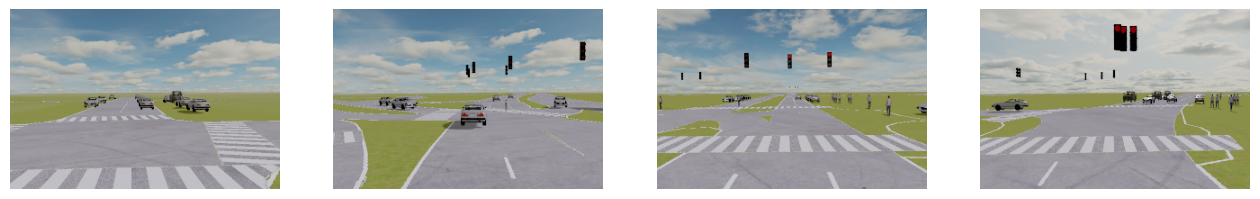

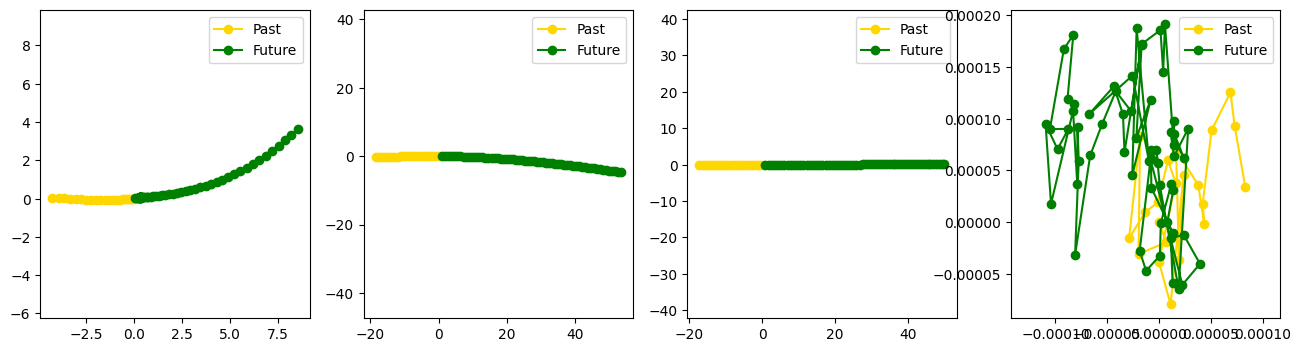

In [2]:
import pickle
import matplotlib.pyplot as plt
import numpy as np
import random

k = 4
# load the data
data = []
for i in random.choices(np.arange(1000), k=k):
    with open(f"train/{i}.pkl", "rb") as f:
        data.append(pickle.load(f))

# plot the camera view of current step for the k examples
fig, axis = plt.subplots(1, k, figsize=(4*k, 4))
for i in range(k):
    axis[i].imshow(data[i]["camera"])
    axis[i].axis("off")
plt.show()

# plot the past and future trajectory of the vehicle
fig, axis = plt.subplots(1, k, figsize=(4*k, 4))
for i in range(k):
    axis[i].plot(data[i]["sdc_history_feature"][:, 0], data[i]["sdc_history_feature"][:, 1], "o-", color="gold", label="Past")
    axis[i].plot(data[i]["sdc_future_feature"][:, 0], data[i]["sdc_future_feature"][:, 1], "o-", color="green", label="Future")
    axis[i].legend()
    axis[i].axis("equal")
plt.show()



In the following cells we will define the classes we need to do a proper training in pytorch.

1. We will start with defining a Dataset class which loads the data and does some basic preprocessing. You can further process this data as you see fit.
2. We then define the logger which receives training metrics and logs and prints/visualizes them. Having a good logger means a lot when dealing with neural network training! The logger implemented here is very simple and we strongly suggest you try other ways of visualizing your losses and metrics. Be creative ;)
3. We then proceed with defining the core part of the pipeline, the model. You are going to mainly implement the model yourself, but we have provided a very simple model so that the code runs as is so that you can see how the whole framework runs all in all.
4. Finally, we define the training funciton which contains the training loop, and we call it to see the magic! You'll need to also do a lot of changes here, from the batch size and learning rate, to adding augmentation schemes and schedulers, etc.

In [3]:
import torch
from torchvision import transforms
from torch.utils.data import Dataset
import pickle

class DrivingDataset(Dataset):
    def __init__(self, file_list, test=False):
        self.samples = file_list
        self.test = test

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        # Load pickle file
        with open(self.samples[idx], 'rb') as f:
            data = pickle.load(f)

        # Convert numpy arrays to tensors
        camera = torch.FloatTensor(data['camera']).permute(2, 0, 1)
        history = torch.FloatTensor(data['sdc_history_feature'])

        # Convert driving_command string to integer
        command_str = data['driving_command']
        command = torch.tensor(command_map[command_str], dtype=torch.long)
        if not self.test:
          future = torch.FloatTensor(data['sdc_future_feature'])
          return {
            'camera': camera,
            'history': history,
            'command': command,
            'future': future
          }
        else:
          return {
            'camera': camera,
            'command': command,
            'history': history
          }

command_map = {'forward': 0, 'left': 1, 'right': 2}

In [4]:
class Logger:
    def __init__(self):
        # Placeholder for potential future configs (e.g., log_dir, wandb_enabled, etc.)
        pass

    def log(self, step=None, **metrics):
        """
        Logs the given metrics.

        Args:
            step (int, optional): The current step or epoch. Useful for tracking.
            **metrics: Arbitrary keyword arguments representing metric names and values.
        """
        prefix = f"[Step {step}] " if step is not None else ""
        metric_str = " | ".join(f"{k}: {v}" for k, v in metrics.items())
        # print(prefix + metric_str)

In [8]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision.models import resnet18
from torchvision.models.mobilenetv2 import mobilenet_v2


class CNNHistoryEncoder(nn.Module):
    def __init__(self, input_dim=3, nb_kernel=32, cnn_feat_size=128, obs_len=21, kernel_size=3, nb_conv=4):
        super().__init__()
        self.cnn = nn.Sequential()
        padding = (kernel_size - 1) // 2
        for i in range(nb_conv):
            in_channels = input_dim if i == 0 else nb_kernel
            self.cnn.add_module(f"conv{i}", nn.Conv1d(in_channels, nb_kernel, kernel_size, padding=padding))
            self.cnn.add_module(f"relu{i}", nn.ReLU())
        self.project = nn.Linear(obs_len * nb_kernel, cnn_feat_size)

    def forward(self, x):  # x: (B, 21, 3)
        x = x.permute(0, 2, 1)  # (B, 3, 21)
        x = self.cnn(x)         # (B, nb_kernel, 21)
        x = x.permute(0, 2, 1).contiguous().view(x.size(0), -1)  # (B, 21 * nb_kernel)
        return F.relu(self.project(F.relu(x)))  # (B, cnn_feat_size)


class CameraHistoryCommandNet(nn.Module):
    def __init__(self,
                 cnn_feat_size=128,
                 motion_feat_size=128,
                 command_feat_size=32,
                 fused_feat_size=256,
                 output_size=60*3):
        super().__init__()

        # Camera encoder
        base_model = resnet18(pretrained=True)
        self.cnn_camera = nn.Sequential(*list(base_model.children())[:-1])  # (B, 512, 1, 1)
        self.camera_proj = nn.Linear(512, cnn_feat_size)

        # History encoder
        self.motion_encoder = CNNHistoryEncoder(cnn_feat_size=motion_feat_size)

        # Driving command embedding
        self.command_embed = nn.Embedding(3, command_feat_size)  # 3: [forward, left, right]

        # Fusion + Decoder
        self.decoder = nn.Sequential(
            nn.Linear(cnn_feat_size + motion_feat_size + command_feat_size, fused_feat_size),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(fused_feat_size, fused_feat_size),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(fused_feat_size, output_size)
        )

    def forward(self, camera, history, command):
        B = camera.size(0)

        # Camera feature
        img_feat = self.cnn_camera(camera).view(B, -1)     # (B, 512)
        img_feat = F.relu(self.camera_proj(img_feat))      # (B, cnn_feat_size)

        # History feature
        hist_feat = self.motion_encoder(history)           # (B, motion_feat_size)

        # Command embedding (assumed to be integer: 0=forward, 1=left, 2=right)
        cmd_feat = self.command_embed(command)             # (B, command_feat_size)

        # Fusion
        fused = torch.cat([img_feat, hist_feat, cmd_feat], dim=1)
        output = self.decoder(fused).view(B, 60, 3)        # (B, 60, 3)
        return output


class TransformerPlanner(nn.Module):
    def __init__(self,
                 cnn_feat_size=128,
                 motion_feat_size=128,
                 command_feat_size=32,
                 nhead=4,
                 num_layers=2,
                 fused_feat_size=256,
                 output_size=60*3):
        super().__init__()

        self.fusion_dim = 128

        # Camera encoder
        base_model = resnet18(pretrained=True)
        self.cnn_camera = nn.Sequential(*list(base_model.children())[:-1])  # (B, 512, 1, 1)
        self.camera_proj = nn.Linear(512, cnn_feat_size)
        self.project_img = nn.Linear(cnn_feat_size, self.fusion_dim)

        # History encoder
        self.motion_encoder = CNNHistoryEncoder(cnn_feat_size=motion_feat_size)
        self.project_hist = nn.Linear(motion_feat_size, self.fusion_dim)

        # Driving command embedding
        self.command_embed = nn.Embedding(3, command_feat_size)  # 3: [forward, left, right]
        self.project_cmd = nn.Linear(command_feat_size, self.fusion_dim)

        # Transformer encoder
        encoder_layer = nn.TransformerEncoderLayer(d_model=self.fusion_dim, nhead=nhead, batch_first=True)
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)

        # Decoder
        self.decoder = nn.Sequential(
            nn.Linear(self.fusion_dim, fused_feat_size),
            nn.Dropout(0.2),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(fused_feat_size, output_size)
        )

    def forward(self, camera, history, command):
        B = camera.size(0)

        # Camera feature
        img_feat = self.cnn_camera(camera).view(B, -1)     # (B, 512)
        img_feat = F.relu(self.camera_proj(img_feat))      # (B, cnn_feat_size)
        img_feat = self.project_img(img_feat)              # (B, fusion_dim)

        # History feature
        hist_feat = self.motion_encoder(history)           # (B, motion_feat_size)
        hist_feat = self.project_hist(hist_feat)           # (B, fusion_dim)

        # Command embedding (int labels: 0, 1, 2)
        cmd_feat = self.command_embed(command)             # (B, command_feat_size)
        cmd_feat = self.project_cmd(F.relu(cmd_feat))      # (B, fusion_dim)

        # Combine features into one token sequence
        token_seq = torch.stack([img_feat, hist_feat, cmd_feat], dim=1)  # (B, 3, fusion_dim)

        fused = self.transformer(token_seq).mean(dim=1)  # (B, fusion_dim)
        output = self.decoder(fused).view(B, 60, 3)      # (B, 60, 3)
        return output


class CNNHistoryEncoder(nn.Module):
    def __init__(self, input_dim=3, nb_kernel=32, cnn_feat_size=128, obs_len=21, kernel_size=3, nb_conv=4):
        super().__init__()
        self.cnn = nn.Sequential()
        padding = (kernel_size - 1) // 2
        for i in range(nb_conv):
            in_channels = input_dim if i == 0 else nb_kernel
            self.cnn.add_module(f"conv{i}", nn.Conv1d(in_channels, nb_kernel, kernel_size, padding=padding))
            self.cnn.add_module(f"relu{i}", nn.ReLU())
        self.project = nn.Linear(obs_len * nb_kernel, cnn_feat_size)

    def forward(self, x):  # x: (B, 21, 3)
        x = x.permute(0, 2, 1)  # (B, 3, 21)
        x = self.cnn(x)         # (B, nb_kernel, 21)
        x = x.permute(0, 2, 1).contiguous().view(x.size(0), -1)  # (B, 21 * nb_kernel)
        return F.relu(self.project(F.relu(x)))  # (B, cnn_feat_size)


class CNNGoalMultiPlanner(nn.Module):
    def __init__(self,
                 cnn_feat_size=128,
                 motion_feat_size=128,
                 command_feat_size=32,
                 fused_feat_size=256,
                 output_steps=60,
                 num_modes=5):
        super().__init__()

        self.num_modes = num_modes
        self.output_steps = output_steps

        # Replace ResNet with MobileNetV2 (lighter and faster)
        base_model = mobilenet_v2(pretrained=True).features
        self.cnn_camera = nn.Sequential(*list(base_model.children()))  # Output: (B, 1280, 6, 10)
        self.global_pool = nn.AdaptiveAvgPool2d((1, 1))
        self.camera_proj = nn.Linear(1280, cnn_feat_size)

        # Motion history encoder
        self.motion_encoder = CNNHistoryEncoder(cnn_feat_size=motion_feat_size)

        # Command embedding
        self.command_embed = nn.Embedding(3, command_feat_size)

        # Goal predictor
        self.goal_predictor = nn.Sequential(
            nn.Linear(cnn_feat_size + motion_feat_size + command_feat_size, 64),
            nn.ReLU(),
            nn.Linear(64, 2)  # (x, y)
        )

        # Fusion MLP
        self.fusion = nn.Sequential(
            nn.Linear(cnn_feat_size + motion_feat_size + command_feat_size + 2, fused_feat_size),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(fused_feat_size, num_modes * output_steps * 2)  # predict N x (60 x 2)
        )

    def forward(self, camera, history, command):
        B = camera.size(0)

        # Camera feature
        img_feat = self.cnn_camera(camera)          # (B, 1280, H, W)
        img_feat = self.global_pool(img_feat).view(B, -1)  # (B, 1280)
        img_feat = F.relu(self.camera_proj(img_feat))      # (B, cnn_feat_size)

        # History feature
        hist_feat = self.motion_encoder(history)    # (B, motion_feat_size)

        # Command embedding
        cmd_feat = self.command_embed(command)      # (B, command_feat_size)

        # Predict goal
        core = torch.cat([img_feat, hist_feat, cmd_feat], dim=1)
        goal = self.goal_predictor(core)            # (B, 2)

        # Full fused feature
        fused = torch.cat([core, goal], dim=1)      # (B, combined + goal)
        traj_out = self.fusion(fused)               # (B, num_modes * 60 * 2)
        traj_out = traj_out.view(B, self.num_modes, self.output_steps, 2)

        return traj_out, goal

In [9]:
def train(model, train_loader, val_loader, optimizer, scheduler, logger, num_epochs=50, label_noise_std=0.01):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = model.to(device)
    criterion = nn.MSELoss()
    save_path = "phase1_model_val_ade.pth"
    best_val_ade = 10

    for epoch in range(num_epochs):
        # Training
        model.train()
        train_loss = 0
        trajectory_weights = torch.linspace(1.5, 0.5, steps=60).to(device)

        for idx, batch in enumerate(train_loader):
            camera = batch['camera'].to(device)
            history = batch['history'].to(device)
            command = batch['command'].to(device)
            future = batch['future'].to(device)
            optimizer.zero_grad()

            pred_multi, _ = model(camera, history, command)
            best_idx = torch.argmin((pred_multi - future[..., :2].unsqueeze(1)).norm(dim=-1).mean(dim=-1), dim=1)
            best_pred = pred_multi[torch.arange(pred_multi.size(0)), best_idx]  # (B, 60, 2)

            # Add label noise during training on x, y only
            if label_noise_std > 0:
                noise = torch.randn_like(future[..., :2]) * label_noise_std
                future_noisy = future.clone()
                future_noisy[..., :2] += noise
            else:
                future_noisy = future

            # Compute loss on noisy labels (x, y only)
            loss = criterion(best_pred[..., :2], future[..., :2])
            loss.backward()
            optimizer.step()

            if idx % 10 == 0:
                logger.log(step=epoch * len(train_loader) + idx, loss=loss.item())
            train_loss += loss.item()

        # Validation
        model.eval()
        val_loss, ade_all, fde_all = 0, [], []
        trajectory_weights = torch.linspace(1.5, 0.5, steps=60).to(device)

        with torch.no_grad():
            for batch in val_loader:
                camera = batch['camera'].to(device)
                history = batch['history'].to(device)
                command = batch['command'].to(device)
                future = batch['future'].to(device)

                pred_multi, _ = model(camera, history, command)
                best_idx = torch.argmin((pred_multi - future[..., :2].unsqueeze(1)).norm(dim=-1).mean(dim=-1), dim=1)
                best_pred = pred_multi[torch.arange(pred_multi.size(0)), best_idx]  # (B, 60, 2)

                loss = criterion(best_pred[..., :2], future[..., :2])

                ADE = torch.norm(best_pred[:, :, :2] - future[:, :, :2], p=2, dim=-1).mean()
                FDE = torch.norm(best_pred[:, -1, :2] - future[:, -1, :2], p=2, dim=-1).mean()

                ade_all.append(ADE.item())
                fde_all.append(FDE.item())
                val_loss += loss.item()

        val_ade = np.mean(ade_all)
        val_fde = np.mean(fde_all)

        # Save the best model
        if val_ade < best_val_ade:
            best_val_ade = val_ade
            torch.save(model.state_dict(), save_path)
            print(f"Saved new best model with ADE: {best_val_ade:.4f}")

        scheduler.step()
        print(f'Epoch {epoch+1}/{num_epochs} | Train Loss: {train_loss/len(train_loader):.4f} | Val Loss: {val_loss/len(val_loader):.4f} | ADE: {np.mean(ade_all):.4f} | FDE: {np.mean(fde_all):.4f}')


In [10]:
import torch.optim as optim
from torch.utils.data import DataLoader
import os

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

train_data_dir = "train"
val_data_dir = "val"

train_files = [os.path.join(train_data_dir, f) for f in os.listdir(train_data_dir) if f.endswith('.pkl')]
val_files = [os.path.join(val_data_dir, f) for f in os.listdir(val_data_dir) if f.endswith('.pkl')]

train_dataset = DrivingDataset(train_files)
val_dataset = DrivingDataset(val_files)

train_loader = DataLoader(train_dataset, batch_size=32, num_workers=2, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, num_workers=2)

model = CameraHistoryCommandNet()

# Initialize model, optimizer, and logger
model = CNNGoalMultiPlanner(
cnn_feat_size=128,
motion_feat_size=128,
command_feat_size=32,
fused_feat_size=256,
output_steps=60,
num_modes=10  # number of trajectory candidates
)

# Move to GPU if available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)

optimizer = optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-5)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.4)  # Adjust learning rate every 10 epochs
logger = Logger()

# Run training
train(model, train_loader, val_loader, optimizer, scheduler, logger, num_epochs=50, label_noise_std=0.01)



/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/mobilenet_v2-b0353104.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v2-b0353104.pth
100%|██████████| 13.6M/13.6M [00:00<00:00, 104MB/s] 


Saved new best model with ADE: 1.8703
Epoch 1/50 | Train Loss: 25.4107 | Val Loss: 3.7322 | ADE: 1.8703 | FDE: 4.3527
Saved new best model with ADE: 1.6977
Epoch 2/50 | Train Loss: 3.8104 | Val Loss: 3.1260 | ADE: 1.6977 | FDE: 4.0093
Epoch 3/50 | Train Loss: 3.3723 | Val Loss: 3.3305 | ADE: 1.8776 | FDE: 3.7663
Saved new best model with ADE: 1.4512
Epoch 4/50 | Train Loss: 3.0762 | Val Loss: 2.3341 | ADE: 1.4512 | FDE: 3.3095
Epoch 5/50 | Train Loss: 3.0918 | Val Loss: 2.5508 | ADE: 1.5653 | FDE: 3.7011
Saved new best model with ADE: 1.4047
Epoch 6/50 | Train Loss: 3.0785 | Val Loss: 2.1755 | ADE: 1.4047 | FDE: 3.3018
Saved new best model with ADE: 1.3082
Epoch 7/50 | Train Loss: 2.7748 | Val Loss: 1.9822 | ADE: 1.3082 | FDE: 3.2261
Saved new best model with ADE: 1.2915
Epoch 8/50 | Train Loss: 2.4315 | Val Loss: 1.9843 | ADE: 1.2915 | FDE: 3.2712
Saved new best model with ADE: 1.2669
Epoch 9/50 | Train Loss: 2.4302 | Val Loss: 1.8663 | ADE: 1.2669 | FDE: 2.9491
Epoch 10/50 | Train Lo

By running the code above, you have trained your first model!
What do you observe in terms of train and val losses? What is this phenomenon called? (Explain in a few lines below)




This model is very simple and does not necessarilly yield the optimal performance. You are asked to implement your own neural network architecture. You can use convolution networks, vision transformers, etc. Try with different architectures, different model sizes, and other hyper parameters such as learning rate and batch size to find the best performance. Other ideas could be to use augmentation thechniques to boost the performance, adding learning rate schedulers, and exploring other loss functions.

Once you are happy with your model, continue with the rest of the notebook to save your checkpoint and also visualize some plans coming from the model. The last cell will provide a `submission_phase1.csv` which you can submit to the leaderboard to see your results on the testing set.

In [11]:
# save the model
torch.save(model.state_dict(), "phase1_model_val_ade.pth")

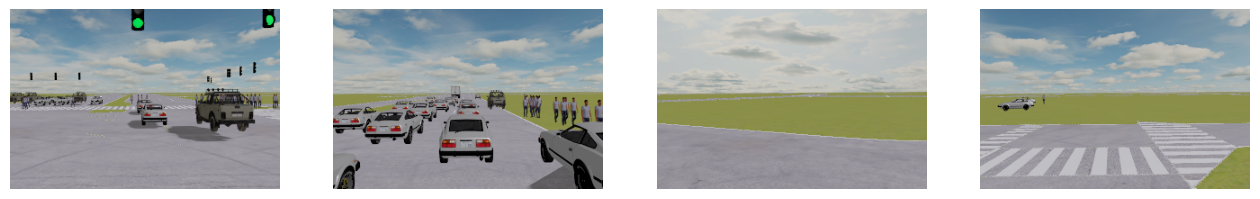

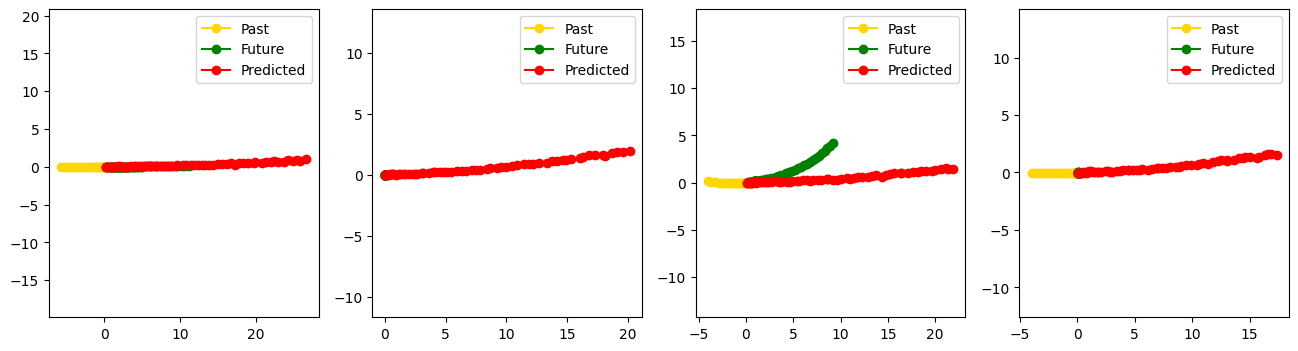

In [31]:
val_batch_zero = next(iter(val_loader))
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
camera = val_batch_zero['camera'].to(device)
history = val_batch_zero['history'].to(device)
command = val_batch_zero['command'].to(device)
future = val_batch_zero['future'].to(device)

model.eval()
with torch.no_grad():
    pred_multi, _ = model(camera, history, command)
    final_pred = pred_multi[:, 0]  # Take the first mode for simplicity

camera = camera.cpu().numpy()
history = history.cpu().numpy()
future = future.cpu().numpy()
pred_future = final_pred.cpu().numpy()
k=4
selected_indices = random.choices(np.arange(len(camera)), k=k)
# plot the camera view of current step for the k examples
fig, axis = plt.subplots(1, k, figsize=(4*k, 4))
for i, idx in enumerate(selected_indices):
    axis[i].imshow(camera[idx].transpose(1, 2, 0)/255)
    axis[i].axis("off")
plt.show()

# plot the past and future trajectory of the vehicle
fig, axis = plt.subplots(1, k, figsize=(4*k, 4))
for i, idx in enumerate(selected_indices):
    axis[i].plot(history[idx, :, 0], history[idx, :, 1], "o-", color="gold", label="Past")
    axis[i].plot(future[idx, :, 0], future[idx, :, 1], "o-", color="green", label="Future")
    axis[i].plot(pred_future[idx, :, 0], pred_future[idx, :, 1], "o-", color="red", label="Predicted")
    axis[i].legend()
    axis[i].axis("equal")
plt.show()

Now we run our model on the test set once, to get the plan of our model and save it for submission. Notice that the ground truth plans are removed for the test set, so you can not calculate the ADE metric on the test set yourself, and need to submit it to the leader board. By running the last cell, you'll be able to see a csv file called `submission_phase1.csv` by clicking on the folder icon on the left. Download it and submit it to the leaderboard to get your score.

In [13]:
with open(f"test_public/0.pkl", "rb") as f:
    data = pickle.load(f)
print(data.keys())
# Note the absence of sdc_future_feature

dict_keys(['camera', 'depth', 'driving_command', 'sdc_history_feature', 'semantic_label'])


In [14]:
import pandas as pd
test_data_dir = "test_public"
test_files = [os.path.join(test_data_dir, f) for f in os.listdir(test_data_dir) if f.endswith('.pkl')]
test_dataset = DrivingDataset(test_files, test=True)
test_loader = DataLoader(test_dataset, batch_size=250, num_workers=2)
model.eval()
all_plans = []
with torch.no_grad():
    for batch in test_loader:
        camera = batch['camera'].to(device)
        history = batch['history'].to(device)
        command = batch['command'].to(device)

        pred_multi, _ = model(camera, history, command)
        pred_future = pred_multi[:, 0]  # pick mode 0 or average across N modes
        all_plans.append(pred_future.cpu().numpy()[..., :2])
all_plans = np.concatenate(all_plans, axis=0)

# Now save the plans as a csv file
pred_xy = all_plans[..., :2]  # shape: (total_samples, T, 2)

# Flatten to (total_samples, T*2)
total_samples, T, D = pred_xy.shape
pred_xy_flat = pred_xy.reshape(total_samples, T * D)

# Build a DataFrame with an ID column
ids = np.arange(total_samples)
df_xy = pd.DataFrame(pred_xy_flat)
df_xy.insert(0, "id", ids)

# Column names: id, x_1, y_1, x_2, y_2, ..., x_T, y_T
new_col_names = ["id"]
for t in range(1, T + 1):
    new_col_names.append(f"x_{t}")
    new_col_names.append(f"y_{t}")
df_xy.columns = new_col_names

# Save to CSV
df_xy.to_csv("submission_phase1.csv", index=False)

print(f"Shape of df_xy: {df_xy.shape}")

Shape of df_xy: (1000, 121)
